# Model Training/Selection/Evaluation

## Steps from instructions

Build 2 or 3 models and select the best one. <br>

### Imports and Loading Data Sets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
X_train = pd.read_csv('X_train.csv').drop('Unnamed: 0', axis=1)
X_test = pd.read_csv('X_test.csv').drop('Unnamed: 0', axis=1)
y_train = pd.read_csv('y_train.csv').drop('Unnamed: 0', axis=1)
y_test = pd.read_csv('y_test.csv').drop('Unnamed: 0', axis=1)

### Pre-Model: PCA

(GMC) I'm going to first do a PCA, which may or may not be a good idea.

In [10]:
from sklearn.decomposition import PCA

In [14]:
X_train.shape

(25008, 63)

In [33]:
pca = PCA(n_components = 10)

In [34]:
pca.fit(X_train)

PCA(n_components=10)

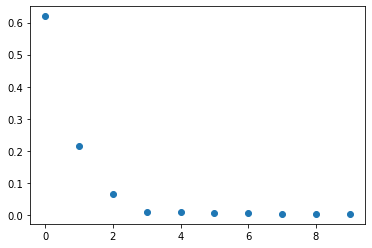

In [35]:
plt.scatter(x = np.arange(0,pca.n_components_), y = pca.explained_variance_ratio_)

(GMC) Two components does great. Three shold be good.
But, I have 5 labels. I think I want to have a minimum of 5 just in case?

Applying the transformation that was fitted on the training set to the training set and the test set:

In [127]:
NUMBER_COMPONENTS = 5

X_train_pca = pca.transform(X_train)
X_train_pca = pd.DataFrame({'PC'+str(i+1): X_train_pca[:,i] for i in range(0,NUMBER_COMPONENTS)})

X_test_pca = pca.transform(X_test)
X_test_pca = pd.DataFrame({'PC'+str(i+1): X_test_pca[:,i] for i in range(0,NUMBER_COMPONENTS)})

In [128]:
X_train_pca5.head()

,PC1,PC2,PC3,PC4,PC5
0,-4.869363,-3.118312,0.237245,0.301092,-0.726552
1,6.298538,5.766404,3.096097,-0.188415,0.120965
2,-1.915807,-5.135583,-2.803126,-0.005263,-0.498360
3,13.218232,5.683658,-1.998450,0.486553,1.853763
4,-3.738462,4.866961,3.223648,0.070555,-0.409274


In [129]:
NUMBER_COMPONENTS = 3

X_train_pca3 = pca.transform(X_train)
X_train_pca3 = pd.DataFrame({'PC'+str(i+1): X_train_pca3[:,i] for i in range(0,NUMBER_COMPONENTS)})

X_test_pca3 = pca.transform(X_test)
X_test_pca3 = pd.DataFrame({'PC'+str(i+1): X_test_pca3[:,i] for i in range(0,NUMBER_COMPONENTS)})

### Pre-model: Encoding Labels

I have roughly ordered them numerically proportional to severity, but the numbering is categorical. It's also easier to read than the long labels.

In [64]:
y_train.value_counts()

CrashSevr                  
C: Possible Injury             10306
B: Suspected Minor Injury       9159
O: No Injury                    2096
A: Suspected Serious Injury     1839
K: Killed                       1608
dtype: int64

In [101]:
"""
0, no injuries
1, possible injury
2, suspected minor injury
3, suspected serious injury
4, killed
"""

encoding = {'O': 0,
            'C': 1,
            'B': 2,
            'A': 3,
            'K': 4}

y_train = y_train.iloc[:,0].str[0]
y_train = y_train.map(encoding)

y_test = y_test.iloc[:,0].str[0]
y_test = y_test.map(encoding)

In [103]:
y_train.value_counts()

1    10306
2     9159
0     2096
3     1839
4     1608
Name: CrashSevr, dtype: int64

### First-Model: Random Forest

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [51]:
rfc = RandomForestClassifier()

In [159]:
# On data set as is
params = {'max_depth': np.arange(25,100,5),
          'min_samples_leaf': [1,2,3,5,8,13,21,34,55,89,144],
          'min_samples_split': np.arange(5,100)}
rscv_rfc = RandomizedSearchCV(estimator = rfc,
                          param_distributions=params,
                          n_iter = 50,
                          cv = 5
                         )

In [160]:
rscv_rfc.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=50,
                   param_distributions={'max_depth': array([25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]),
                                        'min_samples_leaf': [1, 2, 3, 5, 8, 13,
                                                             21, 34, 55, 89,
                                                             144],
                                        'min_samples_split': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
       56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,
       73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
       90, 91, 92, 93, 94, 95, 96, 97, 98, 99])})

In [161]:
results = pd.DataFrame(rscv_rfc.cv_results_)
results.sort_values(by='rank_test_score')[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
15,0.976525,0.019521,0.061512,0.001380,93,1,50,"{'min_samples_split': 93, 'min_samples_leaf': ...",0.491403,0.488405,0.490204,0.487502,0.492501,0.490003,0.001847,1
25,0.966977,0.016590,0.063029,0.003978,58,5,70,"{'min_samples_split': 58, 'min_samples_leaf': ...",0.492803,0.489004,0.488605,0.483303,0.496101,0.489963,0.004309,2
1,0.967888,0.024296,0.061349,0.002511,67,8,25,"{'min_samples_split': 67, 'min_samples_leaf': ...",0.492603,0.492803,0.488804,0.483903,0.491302,0.489883,0.003312,3
17,0.958885,0.006851,0.060929,0.001369,74,2,55,"{'min_samples_split': 74, 'min_samples_leaf': ...",0.489604,0.492203,0.489404,0.483503,0.494101,0.489763,0.003581,4
33,0.980937,0.005983,0.063234,0.001981,72,1,90,"{'min_samples_split': 72, 'min_samples_leaf': ...",0.491803,0.490004,0.486206,0.485503,0.495101,0.489723,0.003564,5


In [162]:
# on PCA
rscv_rfc_pca = RandomizedSearchCV(estimator = rfc,
                          param_distributions=params,
                          n_iter = 50,
                          cv = 5
                         )

In [163]:
rscv_rfc_pca.fit(X_train_pca, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=50,
                   param_distributions={'max_depth': array([25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]),
                                        'min_samples_leaf': [1, 2, 3, 5, 8, 13,
                                                             21, 34, 55, 89,
                                                             144],
                                        'min_samples_split': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
       56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,
       73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
       90, 91, 92, 93, 94, 95, 96, 97, 98, 99])})

In [164]:
results = pd.DataFrame(rscv_pca.cv_results_)
results.sort_values(by='rank_test_score')[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
40,2.231513,0.030816,0.048534,0.000502,55,95,"{'min_samples_leaf': 55, 'max_depth': 95}",0.449620,0.443822,0.458417,0.454109,0.455909,0.452375,0.005152,1
45,2.430394,0.164666,0.053499,0.006500,55,60,"{'min_samples_leaf': 55, 'max_depth': 60}",0.447421,0.445222,0.455018,0.453909,0.459108,0.452136,0.005101,2
25,1.837096,0.025568,0.041778,0.000336,144,45,"{'min_samples_leaf': 144, 'max_depth': 45}",0.449220,0.448021,0.452419,0.450510,0.455309,0.451096,0.002562,3
34,2.094321,0.009852,0.047009,0.001158,89,40,"{'min_samples_leaf': 89, 'max_depth': 40}",0.449020,0.451020,0.454418,0.450310,0.450510,0.451056,0.001806,4
32,2.286214,0.039668,0.049509,0.001856,55,45,"{'min_samples_leaf': 55, 'max_depth': 45}",0.447221,0.444422,0.455218,0.455909,0.452110,0.450976,0.004487,5


In [165]:
rfc_pred = rscv.predict(X_test)
pca_pred = rscv_pca.predict(X_test_pca)

In [135]:
from sklearn.metrics import classification_report

In [166]:
print(classification_report(y_test, rfc_pred))

              precision    recall  f1-score   support

           0       0.50      0.00      0.01       685
           1       0.53      0.68      0.60      3495
           2       0.44      0.55      0.49      2941
           3       0.00      0.00      0.00       635
           4       0.45      0.19      0.26       580

    accuracy                           0.49      8336
   macro avg       0.39      0.28      0.27      8336
weighted avg       0.45      0.49      0.44      8336



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [167]:
print(classification_report(y_test, pca_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       685
           1       0.50      0.63      0.56      3495
           2       0.38      0.49      0.43      2941
           3       0.00      0.00      0.00       635
           4       0.38      0.09      0.15       580

    accuracy                           0.45      8336
   macro avg       0.25      0.24      0.23      8336
weighted avg       0.37      0.45      0.40      8336



They're both really bad at identifying the no injuries and possible serious injuries. <br>
Getting any kind of "decent" score on 1 and 2 aren't very significant, since these classifications are the most represented!

### Second Model: KNN

In [141]:
from sklearn.neighbors import KNeighborsClassifier

In [142]:
knn = KNeighborsClassifier()

In [168]:
params = {'n_neighbors': np.arange(3,300)}
rscv_knn = RandomizedSearchCV(estimator = knn,
                             param_distributions = params,
                             n_iter = 25,
                             cv =5)

In [169]:
rscv_knn.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=25,
                   param_distributions={'n_neighbors': array([  3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
        55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
        68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
        81,  82,  83,  84,  85...
       211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223,
       224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236,
       237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249,
       250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262,
       263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275,
       276, 277, 278, 279, 280, 281, 282, 283, 28

In [170]:
rscv_knn.best_params_

{'n_neighbors': 101}

In [176]:
results = pd.DataFrame(rscv_knn.cv_results_)
results.sort_values(by='rank_test_score')[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
22,0.067173,0.003429,1.479035,0.011142,101,{'n_neighbors': 101},0.451619,0.450620,0.459016,0.454709,0.459708,0.455135,0.003712,1
21,0.068213,0.004455,1.545873,0.012051,121,{'n_neighbors': 121},0.452419,0.449620,0.454618,0.454509,0.461308,0.454495,0.003860,2
24,0.066522,0.004550,1.474236,0.017384,98,{'n_neighbors': 98},0.448421,0.448621,0.458617,0.454309,0.461508,0.454295,0.005242,3
5,0.078439,0.003957,1.815156,0.023080,95,{'n_neighbors': 95},0.451020,0.451220,0.459416,0.451110,0.458708,0.454295,0.003900,4
9,0.080622,0.005944,1.895146,0.076433,106,{'n_neighbors': 106},0.450220,0.448421,0.459216,0.455309,0.457109,0.454055,0.004099,5


In [171]:
knn_pred = rscv.predict(X_test)
print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

           0       0.50      0.00      0.01       685
           1       0.53      0.68      0.60      3495
           2       0.44      0.55      0.49      2941
           3       0.00      0.00      0.00       635
           4       0.45      0.19      0.26       580

    accuracy                           0.49      8336
   macro avg       0.39      0.28      0.27      8336
weighted avg       0.45      0.49      0.44      8336



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [172]:
rscv_knn_pca = RandomizedSearchCV(estimator = knn,
                                 param_distributions = params,
                                 n_iter = 25,
                                 cv = 5)

In [173]:
rscv_knn_pca.fit(X_train_pca, y_train)

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=25,
                   param_distributions={'n_neighbors': array([  3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
        55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
        68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
        81,  82,  83,  84,  85...
       211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223,
       224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236,
       237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249,
       250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262,
       263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275,
       276, 277, 278, 279, 280, 281, 282, 283, 28

In [174]:
rscv_knn_pca.best_params_

{'n_neighbors': 288}

In [177]:
knn_pca_pred = rscv_knn_pca.predict(X_test_pca)
print(classification_report(y_test, knn_pca_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       685
           1       0.48      0.64      0.55      3495
           2       0.38      0.48      0.42      2941
           3       0.00      0.00      0.00       635
           4       0.00      0.00      0.00       580

    accuracy                           0.44      8336
   macro avg       0.17      0.22      0.19      8336
weighted avg       0.34      0.44      0.38      8336



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Intermediate Asessment

All of these models are really struggling with classes 0 and 3 (and to an extent, 4), and these are the classes that are the least represented.

In [185]:
y_train.value_counts()/y_train.value_counts().sum()

1    0.412108
2    0.366243
0    0.083813
3    0.073536
4    0.064299
Name: CrashSevr, dtype: float64

Different models/tunings need to be explored.

In [186]:
from sklearn.svm import SVC

In [193]:
svc = SVC()

In [199]:
params = {'C': [0.01, 0.1, 1],
          'degree' : np.arange(3,5),
         }

In [200]:
from sklearn.model_selection import GridSearchCV

In [201]:
svc_model = GridSearchCV(estimator = svc,
                         param_grid = params,
                         cv = 5)

In [202]:
svc_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 1], 'degree': array([3, 4])})

In [203]:
svc_model.best_params_

{'C': 1, 'degree': 3}

In [204]:
svc_pred = svc_model.predict(X_test)
print(classification_report(y_test, svc_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       685
           1       0.54      0.63      0.58      3495
           2       0.42      0.62      0.50      2941
           3       0.00      0.00      0.00       635
           4       0.00      0.00      0.00       580

    accuracy                           0.48      8336
   macro avg       0.19      0.25      0.22      8336
weighted avg       0.38      0.48      0.42      8336



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Going to try a larger set without (or less) cross validation.

In [211]:
svc0 = SVC(C=1.5)

In [212]:
svc0.fit(X_train, y_train)

SVC(C=1.5)

In [213]:
# SVC fitting is slow!
svc0_pred = svc0.predict(X_test)
print(classification_report(y_test, svc0_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       685
           1       0.54      0.63      0.58      3495
           2       0.42      0.62      0.50      2941
           3       0.00      0.00      0.00       635
           4       0.00      0.00      0.00       580

    accuracy                           0.48      8336
   macro avg       0.19      0.25      0.22      8336
weighted avg       0.38      0.48      0.42      8336



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Maybe I'll try logistic regression...

In [215]:
from sklearn.linear_model import LogisticRegression

In [218]:
# Going to basically try an out of the box trial first
logit = LogisticRegression(max_iter = 10**6)

In [219]:
logit.fit(X_train, y_train)

LogisticRegression(max_iter=1000000)

In [220]:
logit_pred = logit.predict(X_test)
print(classification_report(y_test, logit_pred))

              precision    recall  f1-score   support

           0       0.25      0.00      0.00       685
           1       0.53      0.66      0.59      3495
           2       0.44      0.55      0.49      2941
           3       0.62      0.01      0.02       635
           4       0.45      0.29      0.36       580

    accuracy                           0.49      8336
   macro avg       0.46      0.30      0.29      8336
weighted avg       0.48      0.49      0.45      8336



In [222]:
pd.DataFrame(logit_pred).value_counts()

1    4333
2    3619
4     372
3       8
0       4
dtype: int64

In [223]:
pd.DataFrame(y_test).value_counts()

CrashSevr
1            3495
2            2941
0             685
3             635
4             580
dtype: int64

Already looks a bit better than other models! It's acutally predicting some of the more serious injuries.

In [262]:
logit = LogisticRegression(max_iter = 10**6)

In [263]:
params = {'C': np.arange(0.01,10,0.01)}

In [264]:
rscv_logit = RandomizedSearchCV(estimator = logit,
                                param_distributions = params,
                                n_iter = 25,
                                cv=3)

In [265]:
rscv_logit.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=LogisticRegression(max_iter=1000000),
                   n_iter=25,
                   param_distributions={'C': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0...
       9.25, 9.26, 9.27, 9.28, 9.29, 9.3 , 9.31, 9.32, 9.33, 9.34, 9.35,
       9.36, 9.37, 9.38, 9.39, 9.4 , 9.41, 9.42, 9.43, 9.44, 9.45, 9.46,
       9.47, 9.48, 9.49, 9.5 , 9.51, 9.52, 9.53, 9.54, 9.55, 9.56, 9.57,
       9.58, 9.59, 9.6 , 9.61, 9.62, 9.63, 9.64, 9.65, 9.66, 9.67, 9.68,
       9.69, 9.7 , 9.71, 9.72, 9.73, 9.74, 9.75, 9.76, 9.77, 9.78, 9.79,
       9.8 , 9.81, 9.82, 9.83, 9.84, 9.85, 9.86, 9.87, 9.88, 9.89, 9.9 ,
       9.91, 9.92, 9.93, 9.94, 9.95, 9.96, 9.97, 9.98, 9.99])})

In [266]:
results = pd.DataFrame(rscv_logit.cv_results_)
results.sort_values(by='rank_test_score')[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
19,6.632151,0.641469,0.005863,0.002073,5.47,{'C': 5.47},0.490763,0.490283,0.489923,0.490323,0.000344,1
13,6.440988,1.014117,0.005980,0.002450,4.26,{'C': 4.26},0.490523,0.490523,0.489803,0.490283,0.000339,2
9,6.837015,0.737557,0.005821,0.001911,3.84,{'C': 3.84},0.490403,0.490523,0.489923,0.490283,0.000259,2
14,7.136296,0.365669,0.005451,0.002251,6.96,{'C': 6.96},0.490643,0.490643,0.489563,0.490283,0.000509,4
5,6.713712,0.331745,0.007124,0.002432,4.4,{'C': 4.3999999999999995},0.490283,0.490523,0.489923,0.490243,0.000246,5


In [271]:
results.sort_values(by='rank_test_score', ascending=False)[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
11,5.859365,0.246121,0.004437,0.000228,0.22,{'C': 0.22},0.489203,0.491003,0.489563,0.489923,0.000777,25
12,6.712310,0.276425,0.008814,0.000198,6.77,{'C': 6.77},0.490163,0.490163,0.489683,0.490003,0.000226,21
7,6.904558,0.619266,0.004507,0.000351,3.75,{'C': 3.75},0.490043,0.490043,0.489923,0.490003,0.000057,21
21,6.594241,0.798666,0.004411,0.000163,6.41,{'C': 6.41},0.490403,0.489923,0.489683,0.490003,0.000299,21
17,6.291880,0.452968,0.004439,0.000187,7.81,{'C': 7.81},0.490163,0.490283,0.489563,0.490003,0.000315,21


In [272]:
rscv_logit_pred = rscv_logit.predict(X_test)
print(classification_report(y_test, rscv_logit_pred))

              precision    recall  f1-score   support

           0       0.25      0.00      0.00       685
           1       0.53      0.66      0.59      3495
           2       0.44      0.55      0.49      2941
           3       0.71      0.01      0.02       635
           4       0.45      0.29      0.35       580

    accuracy                           0.49      8336
   macro avg       0.48      0.30      0.29      8336
weighted avg       0.49      0.49      0.45      8336



In [273]:
rscv_logit_pca = RandomizedSearchCV(estimator = logit,
                                param_distributions = params,
                                n_iter = 25,
                                cv=3)

In [274]:
rscv_logit_pca.fit(X_train_pca, y_train)

RandomizedSearchCV(cv=3, estimator=LogisticRegression(max_iter=1000000),
                   n_iter=25,
                   param_distributions={'C': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0...
       9.25, 9.26, 9.27, 9.28, 9.29, 9.3 , 9.31, 9.32, 9.33, 9.34, 9.35,
       9.36, 9.37, 9.38, 9.39, 9.4 , 9.41, 9.42, 9.43, 9.44, 9.45, 9.46,
       9.47, 9.48, 9.49, 9.5 , 9.51, 9.52, 9.53, 9.54, 9.55, 9.56, 9.57,
       9.58, 9.59, 9.6 , 9.61, 9.62, 9.63, 9.64, 9.65, 9.66, 9.67, 9.68,
       9.69, 9.7 , 9.71, 9.72, 9.73, 9.74, 9.75, 9.76, 9.77, 9.78, 9.79,
       9.8 , 9.81, 9.82, 9.83, 9.84, 9.85, 9.86, 9.87, 9.88, 9.89, 9.9 ,
       9.91, 9.92, 9.93, 9.94, 9.95, 9.96, 9.97, 9.98, 9.99])})

In [276]:
rscv_logit_pca_pred = rscv_logit_pca.predict(X_test_pca)
print(classification_report(y_test, rscv_logit_pca_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       685
           1       0.46      0.61      0.52      3495
           2       0.40      0.50      0.44      2941
           3       0.00      0.00      0.00       635
           4       0.00      0.00      0.00       580

    accuracy                           0.43      8336
   macro avg       0.17      0.22      0.19      8336
weighted avg       0.33      0.43      0.38      8336



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
